# Optimization I - Project 3 – Non Linear Programming - Group 4

## Feature Selection - MIQP vs Lasso

## Team

<pre>
<b>Name:</b> Manideep Telukuntla     <b>UT EID:</b> mt39528
<b>Name:</b> Vaishnavi Ganesh        <b>UT EID:</b> vg23798
<b>Name:</b> Bin Yang                <b>UT EID:</b> by4325
<b>Name:</b> Sanjana Nayak           <b>UT EID:</b> svn378
</pre>

In [42]:
# Set time limit
time_limit = 3600

In [43]:
# import statements
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path
import time
import warnings

warnings.filterwarnings('ignore')

## Loading Train & Test Datasets

In [44]:
train_data = pd.read_csv("training_data.csv")

In [45]:
train_data.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [46]:
test_data = pd.read_csv("test_data.csv")

In [47]:
test_data.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


## Variable Selection Methods: Direct vs. Indirect

In predictive modeling, variable selection is essential. This notebook discusses two methods, Direct Variable Selection and Indirect Variable Selection using LASSO.

### Direct Variable Selection - MIQP Problem

The Direct Variable Selection method incorporates binary variables, \( z_j \), into the ordinary least squares problem. It forces the corresponding values of \( \beta_j \) to be zero when \( z_j \) is zero, thereby allowing the selection of at most \( k \) variables from the set \( X \).

The formulation involves minimizing the sum of squared residuals, subject to binary variable constraints and a constraint on the number of selected variables:

\$
\min_{\beta, z} \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + \ldots + \beta_m x_{im} - y_i)^2
\$
subject to:
\$
-Mz_j \leq \beta_j \leq Mz_j \text{ for } j = 1, 2, 3, \ldots , m
\$
\$
\sum_{j=1}^{m} z_j \leq k \quad (z_j \text{ are binary})
\$

### Indirect Variable Selection - LASSO

The Indirect Variable Selection method utilizes the LASSO regression, minimizing the sum of squared residuals and a regularization term multiplied by a hyperparameter \( \lambda \). This approach effectively shrinks \( \beta \) values, forcing some to be zero.

The LASSO regression formulation is as follows:

\$
\min_{\beta} \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + \ldots + \beta_m x_{im} - y_i)^2 + \lambda \sum_{j=1}^{m} |\beta_j|
\$

In this project, `scikit-learn` will be used to solve the LASSO problem.

#### Overview
- **Direct Variable Selection**: Controls variable selection via binary variables to enforce zero coefficients.
- **Indirect Variable Selection (LASSO)**: Employs regularization (L1) to shrink coefficients and force some to zero.

Both methods are useful for feature selection, where the choice between them may vary based on the problem requirements and dataset characteristics.

In [48]:
num_variables = len(train_data.columns)

In [49]:
num_records = len(train_data)

In [50]:
lm = gp.Model()
beta = lm.addMVar(num_variables,lb=-np.inf)

In [51]:
lm = gp.Model()
beta = lm.addMVar(num_variables,lb=-np.inf)
lm.setObjective(
    gp.quicksum(
    (beta[0] + gp.quicksum(beta[j] * train_data[f"X{j}"][i] for j in range(1, num_variables)) - train_data["y"][i]) *
    (beta[0] + gp.quicksum(beta[j] * train_data[f"X{j}"][i] for j in range(1, num_variables)) - train_data["y"][i])
    for i in range(num_records)
    )
)

lm.Params.OutputFlag = 0 # tell gurobi to shut up!!
lm.optimize()

In [52]:
beta.x

array([ 0.96181997, -0.03124313,  0.10830046,  0.33658635,  0.34788706,
       -0.07805158, -0.26870205,  0.56917466, -0.09265014, -2.80170764,
        0.5961224 ,  0.00342708, -0.40802441,  0.64028772,  0.34250235,
       -0.35811603, -0.22662545,  0.47574886,  0.61818724,  0.5627165 ,
        0.91343131,  0.1266948 , -0.44072877, -1.13218924,  0.71016955,
        0.08281624, -1.48717747,  0.02439235, -0.38572888,  0.35864434,
        0.08111228, -0.18165492,  0.74866389, -0.04257738,  1.2137678 ,
       -0.53326153,  0.23934142,  0.25972978, -0.13112438, -1.09826371,
        0.45402031, -0.59555224,  0.33959881, -0.4208102 ,  0.04031396,
        1.8661944 , -0.01828012,  1.07420755,  0.147014  ,  0.56919769,
       -0.22109118])

In [53]:
from sklearn.linear_model import LinearRegression
import pandas as pd

X = train_data.drop(columns=["y"])  # Features
y = train_data["y"]  # Target variable

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Get the coefficients (model parameters)
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-0.03124313  0.10830046  0.33658635  0.34788706 -0.07805158 -0.26870205
  0.56917466 -0.09265014 -2.80170764  0.5961224   0.00342708 -0.40802441
  0.64028772  0.34250235 -0.35811603 -0.22662545  0.47574886  0.61818724
  0.5627165   0.91343131  0.1266948  -0.44072877 -1.13218924  0.71016955
  0.08281624 -1.48717747  0.02439235 -0.38572888  0.35864434  0.08111228
 -0.18165492  0.74866389 -0.04257738  1.2137678  -0.53326153  0.23934142
  0.25972978 -0.13112438 -1.09826371  0.45402031 -0.59555224  0.33959881
 -0.4208102   0.04031396  1.8661944  -0.01828012  1.07420755  0.147014
  0.56919769 -0.22109118]
Intercept: 0.961819970676987


## Part 1 & 2
On canvas there are 2 data sets that include x and y data. One data set is a training data
set, and one is a test data set. You will follow the data science pipeline carefully here.
You will first do 10-fold cross validation on the training set to pick k or 𝜆. Then using the
optimal values of k or 𝜆 you will fit your 𝛽s using the entire training set. Then with
those 𝛽s you will make a prediction of the y values on the test set, and compare your
prediction of y, to the true value of y in the test set.

In order to do cross validation on the MIQP model you will have to write your own cross
validation code. Randomly shuffle your data and split it into 10 folds. You can use the
‘np.random.choice()’ function in Python to shuffle your data. There are 50 X variables,
and you will need to try k = 5, 10, 15, …, 50 in your cross validation. This means to do
10-fold cross validation with all possible values of k, you will have to solve an MIQP
model 100 times! Pick the value of k that corresponds to the smallest cross validation
error: for a given value of k, sum each validation set’s sum of squared errors using the
𝛽s found using the other 9 folds’ data to solve the MIQP. When k is 5 or 50, gurobi
should solve the problem pretty quickly, but when k is 25 it will probably take a long
time. Therefore, you should set a time limit for gurobi to solve each problem. Don’t let
the entire process run for any longer than 12 hours. Again, be smart about setting this
up, so that you can run it once, save the results, and then import those results when you
create the final version of your python code and pdf file. Also, set a time limit variable
at the very beginning of your python code so that we can shorten the runtime of your
code when we grade it.
- a. It is very important to remember that gurobi assumes all decision variables are
non-negative. In order to allow your 𝛽s to be negative or positive you must set
the lb for the appropriate decision variables.
- b. It is also very important that you choose M to be large enough so that no value
of 𝛽 is equal to M or -M. If you solve the problem and one of your 𝛽s is M or -M
then you should double M and resolve the problem. Repeat this process until no
𝛽 is equal to M or -M.

In [54]:
# Function to solve MIQP
def solve_MIQP(train_set, k, M, time_limit):
    num_variables = len(train_set.columns)
    num_records = len(train_set)

    lm = gp.Model()
    beta = lm.addMVar(num_variables, lb=-np.inf)

    # Set up the objective function
    lm.setObjective(
        gp.quicksum(
            (beta[0] + gp.quicksum(beta[j] * train_set.iloc[i, j] for j in range(1, num_variables)) - train_set.iloc[i, 0]) *
            (beta[0] + gp.quicksum(beta[j] * train_set.iloc[i, j] for j in range(1, num_variables)) - train_set.iloc[i, 0])
            for i in range(num_records)
        )
    )

    # Set constraints for non-negativity and sparsity (sum of non-zero variables)
    z = lm.addVars(num_variables, vtype=gp.GRB.BINARY)

    lm.addConstrs((-M * z[j] <= beta[j] for j in range(1, num_variables)))
    lm.addConstrs((beta[j] <= M * z[j] for j in range(1, num_variables)))

    lm.addConstr(gp.quicksum(z[j] for j in range(1, num_variables)) <= k)

    lm.Params.OutputFlag = 0  # Set Gurobi to be silent
    lm.Params.TimeLimit = time_limit
    lm.optimize()

    # Get the solution and return the beta values
    if lm.status == gp.GRB.OPTIMAL:
        return [beta[j].X for j in range(num_variables)]
    else:
        return None

# Given training and test datasets
train_data = train_data  # Your training dataset
test_data = test_data  # Your test dataset

# Define the number of records and the number of folds for cross-validation
num_records = len(train_data)
num_folds = 10

# Define the range of k values to try
k_values = range(5, 51, 5)

# Initialize best_k and best_error
best_k = None
best_error = float('inf')
M = 100  # Initial value of M

np.random.seed(42)

# Randomly shuffle the indices of the dataset
indices = np.random.choice(num_records, num_records, replace=False)

# Create an empty DataFrame to store the results
num_beta_columns = len(train_data.columns)
results_df = pd.DataFrame(columns=['k', 'fold', 'validation_error', 'train_error', 'average_total_error'] + [f'beta_{i}' for i in range(num_beta_columns)])

for k in k_values:
    total_error = 0
    
    for fold in range(num_folds):

        # Split the indices into training and validation sets
        fold_size = num_records // num_folds
        validation_indices = indices[fold * fold_size: (fold + 1) * fold_size]
        train_indices = np.setdiff1d(indices, validation_indices)

        # Get data for the current fold based on the indices
        validation_set = train_data.iloc[validation_indices]
        train_set = train_data.iloc[train_indices]

        # Solve the MIQP model for the current k using the train_set
        start_time = time.time()  # Start the timer
        beta = solve_MIQP(train_set, k, M, time_limit)
        
        if time.time() - start_time > time_limit:
            print(f"Time limit exceeded for k = {k} and fold = {fold}. Moving to the next fold.")
        else:
            print(f"Time limit didn't exceeded for k = {k} and fold = {fold}. Moving to the next fold.")

        if beta:
            # Calculate validation error using the validation set
            validation_predictions = validation_set.iloc[:, 1:].dot(beta[1:]) + beta[0]
            validation_error = mean_squared_error(validation_set["y"], validation_predictions)

            # Calculate train error using the training set
            train_predictions = train_set.iloc[:, 1:].dot(beta[1:]) + beta[0]
            train_error = mean_squared_error(train_set["y"], train_predictions)

            # Add data to the DataFrame
            results_df = results_df.append({
                'k': k,
                'fold': fold,
                'validation_error': validation_error,
                'train_error': train_error,
                'average_total_error': None,  # Placeholder for average_total_error
                **{f'beta_{i}': beta[i] for i in range(num_beta_columns)}  # Store beta coefficients
            }, ignore_index=True)
            
            total_error += validation_error

    # Calculate the average total error for all folds for the current k
    total_error = total_error / num_folds
    
    # Update the DataFrame with the average total error
    results_df.loc[results_df['k'] == k, 'average_total_error'] = total_error
    
    if total_error < best_error:
        best_error = total_error
        best_k = k

Time limit didn't exceeded for k = 5 and fold = 0. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 1. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 2. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 3. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 4. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 5. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 6. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 7. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 8. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 9. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 0. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 1. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 2. Moving to the next fold.
Time limi

In [58]:
best_error
print(f"Least Error: {best_error}")

Least Error: 2.8158640525736836


In [59]:
print(f"Best k: {best_k}")

Best k: 10


In [60]:
results_df.to_csv("results_MIQP.csv")

In [61]:
results_df

,k,fold,validation_error,train_error,average_total_error,beta_0,beta_1,beta_2,beta_3,beta_4,...,beta_41,beta_42,beta_43,beta_44,beta_45,beta_46,beta_47,beta_48,beta_49,beta_50
0,5,0,4.843393,3.340108,3.656458,1.0331616447621468,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8902461271118571,0.0,0.879714780890828,0.0,0.0,0.0
1,5,1,3.050839,3.532754,3.656458,1.06597097725768,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8992550121579712,0.0,0.8902197651115359,0.0,0.0,0.0
2,5,2,3.056338,3.544048,3.656458,1.0930730756855234,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.93349902685701,0.0,0.8955130231813888,0.0,0.0,0.0
3,5,3,2.905611,3.558526,3.656458,0.9932984368246316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8896332165751133,0.0,0.8127496734067657,0.0,0.0,0.0
4,5,4,4.758383,3.368634,3.656458,1.0898290895627152,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.817657932442472,0.0,0.8896874266410678,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,5,2.694549,2.096472,3.361816,0.9271385296050916,-0.18859347260205084,-0.04131340478564027,0.31490416763088547,0.3964048288775075,...,-0.7793975679221461,0.33592668318331675,-0.5612998765613497,-0.07065035719428181,1.9279503498911765,-0.039311846253383465,1.177801998385931,0.23881222760817877,0.7199593656331587,-0.30794281348352115
96,50,6,3.002748,2.060630,3.361816,0.9716009048630005,-0.07745350611203605,-0.006449629531957157,0.3506624308711679,0.34338563938013067,...,-0.7506804172373336,0.5268790942194528,-0.7161778023820631,0.04908618367049655,1.8894830409824266,0.005109864905890049,1.0915133369803982,0.33262617348995605,0.6902447520584332,-0.31726471852728366
97,50,7,2.542203,2.097745,3.361816,1.012705391446481,-0.16567692358412955,0.23378159807340637,0.46514941904563045,0.48318979246278104,...,-1.018680669660796,0.5665373252344637,-0.8158694432547122,-0.116420328920114,1.938403729773654,-0.04127530356241493,1.0699134151902285,0.4817675271547728,0.8150440246995032,-0.22782481144474787
98,50,8,4.163277,1.943516,3.361816,0.9962422480003453,-0.010889496453032166,0.09035691882772312,0.4280214556126509,0.26077512225874955,...,-0.3755429870693945,0.3425946328319185,-0.3405280014519434,0.28415515609877673,1.9293027226551658,-0.06031433465361147,1.0829212728930173,-0.02415719612946532,0.44272664654337746,-0.170216331284891


### Calculating SSE instead of MSE 

In [20]:
# Given training and test datasets
train_data = train_data  # Your training dataset
test_data = test_data  # Your test dataset

# Define the number of records and the number of folds for cross-validation
num_records = len(train_data)
num_folds = 10

# Define the range of k values to try
k_values = range(5, 51, 5)

# Initialize best_k and best_error
best_k_sse = None
best_error_sse = float('inf')
M = 100  # Initial value of M

np.random.seed(42)

# Randomly shuffle the indices of the dataset
indices = np.random.choice(num_records, num_records, replace=False)

# Create an empty DataFrame to store the results
num_beta_columns = len(train_data.columns)
results_df_sse = pd.DataFrame(columns=['k', 'fold', 'validation_error', 'train_error', 'average_total_error'] + [f'beta_{i}' for i in range(num_beta_columns)])

for k in k_values:
    total_error = 0
    
    for fold in range(num_folds):

        # Split the indices into training and validation sets
        fold_size = num_records // num_folds
        validation_indices = indices[fold * fold_size: (fold + 1) * fold_size]
        train_indices = np.setdiff1d(indices, validation_indices)

        # Get data for the current fold based on the indices
        validation_set = train_data.iloc[validation_indices]
        train_set = train_data.iloc[train_indices]

        # Solve the MIQP model for the current k using the train_set
        start_time = time.time()  # Start the timer
        beta = solve_MIQP(train_set, k, M, time_limit)
        
        if time.time() - start_time > time_limit:
            print(f"Time limit exceeded for k = {k} and fold = {fold}. Moving to the next fold.")
        else:
            print(f"Time limit didn't exceeded for k = {k} and fold = {fold}. Moving to the next fold.")

        if beta:
            # Calculate validation error using the validation set
            validation_predictions = validation_set.iloc[:, 1:].dot(beta[1:]) + beta[0]
            validation_error = ((validation_set.iloc[:, 0] - validation_predictions) ** 2).sum()  # SSE for validation

            # Calculate train error using the training set
            train_predictions = train_set.iloc[:, 1:].dot(beta[1:]) + beta[0]
            train_error = ((train_set.iloc[:, 0] - train_predictions) ** 2).sum()  # SSE for training

            # Add data to the DataFrame
            results_df_sse = results_df_sse.append({
                'k': k,
                'fold': fold,
                'validation_error': validation_error,
                'train_error': train_error,
                'average_total_error': None,  # Placeholder for average_total_error
                **{f'beta_{i}': beta[i] for i in range(num_beta_columns)}  # Store beta coefficients
            }, ignore_index=True)
            
            total_error += validation_error

    # Calculate the average total error for all folds for the current k
    total_error = total_error / num_folds
    
    # Update the DataFrame with the average total error
    results_df_sse.loc[results_df_sse['k'] == k, 'average_total_error'] = total_error
    
    if total_error < best_error_sse:
        best_error_sse = total_error
        best_k_sse = k

Time limit didn't exceeded for k = 5 and fold = 0. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 1. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 2. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 3. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 4. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 5. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 6. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 7. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 8. Moving to the next fold.
Time limit didn't exceeded for k = 5 and fold = 9. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 0. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 1. Moving to the next fold.
Time limit didn't exceeded for k = 10 and fold = 2. Moving to the next fold.
Time limi

In [22]:
best_error_sse
print(f"Least Error: {best_error_sse}")

Least Error: 70.39660131434212


In [23]:
print(f"Best k: {best_k_sse}")

Best k: 10


In [24]:
results_df_sse

,k,fold,validation_error,train_error,average_total_error,beta_0,beta_1,beta_2,beta_3,beta_4,...,beta_41,beta_42,beta_43,beta_44,beta_45,beta_46,beta_47,beta_48,beta_49,beta_50
0,5,0,121.084832,751.524368,91.411453,1.0331616447621468,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8902461271118571,0.0,0.879714780890828,0.0,0.0,0.0
1,5,1,76.270963,794.869634,91.411453,1.06597097725768,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8992550121579712,0.0,0.8902197651115359,0.0,0.0,0.0
2,5,2,76.408462,797.410700,91.411453,1.0930730756855234,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.93349902685701,0.0,0.8955130231813888,0.0,0.0,0.0
3,5,3,72.640284,800.668270,91.411453,0.9932984368246316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.8896332165751133,0.0,0.8127496734067657,0.0,0.0,0.0
4,5,4,118.959584,757.942749,91.411453,1.0898290895627152,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.817657932442472,0.0,0.8896874266410678,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,5,67.363716,471.706101,84.045402,0.9271385296050916,-0.18859347260205084,-0.04131340478564027,0.31490416763088547,0.3964048288775075,...,-0.7793975679221461,0.33592668318331675,-0.5612998765613497,-0.07065035719428181,1.9279503498911765,-0.039311846253383465,1.177801998385931,0.23881222760817877,0.7199593656331587,-0.30794281348352115
96,50,6,75.068711,463.641717,84.045402,0.9716009048630005,-0.07745350611203605,-0.006449629531957157,0.3506624308711679,0.34338563938013067,...,-0.7506804172373336,0.5268790942194528,-0.7161778023820631,0.04908618367049655,1.8894830409824266,0.005109864905890049,1.0915133369803982,0.33262617348995605,0.6902447520584332,-0.31726471852728366
97,50,7,63.555081,471.992701,84.045402,1.012705391446481,-0.16567692358412955,0.23378159807340637,0.46514941904563045,0.48318979246278104,...,-1.018680669660796,0.5665373252344637,-0.8158694432547122,-0.116420328920114,1.938403729773654,-0.04127530356241493,1.0699134151902285,0.4817675271547728,0.8150440246995032,-0.22782481144474787
98,50,8,104.081937,437.291152,84.045402,0.9962422480003453,-0.010889496453032166,0.09035691882772312,0.4280214556126509,0.26077512225874955,...,-0.3755429870693945,0.3425946328319185,-0.3405280014519434,0.28415515609877673,1.9293027226551658,-0.06031433465361147,1.0829212728930173,-0.02415719612946532,0.44272664654337746,-0.170216331284891


### Mean Squared Error comparison by k

In [62]:
results_df = pd.read_csv('results_MIQP.csv')
results_df = results_df.iloc[:, 1:]

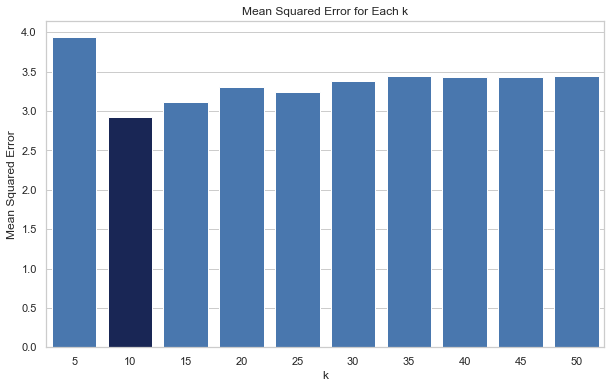

In [63]:
unique_results = results_df[['k', 'average_total_error']].drop_duplicates()

# Convert 'average_total_error' to numeric
unique_results['average_total_error'] = pd.to_numeric(unique_results['average_total_error'])

# Find the row with the minimum average_total_error
min_error_row = unique_results.loc[unique_results['average_total_error'].idxmin()]

# Set the Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use a single solid color for all bars
# bar_color = sns.color_palette("Set3")[4]

# Create a bar plot with a single solid color for all bars
ax = sns.barplot(x='k', y='average_total_error', data=unique_results, color="#3876BF")

# Highlight the bar with the least error value
min_error_bar = ax.patches[unique_results['k'].tolist().index(min_error_row['k'])]
min_error_bar.set_facecolor('#192655')

# ax.yaxis.grid(False)

# Add labels and title
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error for Each k')

# plt.savefig('mse_miqp.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Sum of Squared Error comparison by k

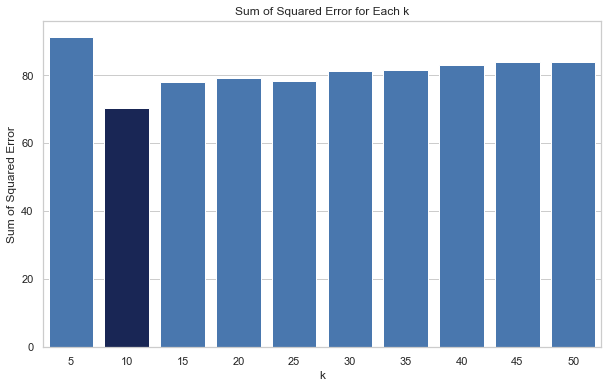

In [39]:
unique_results = results_df_sse[['k', 'average_total_error']].drop_duplicates()

# Convert 'average_total_error' to numeric
unique_results['average_total_error'] = pd.to_numeric(unique_results['average_total_error'])

# Find the row with the minimum average_total_error
min_error_row = unique_results.loc[unique_results['average_total_error'].idxmin()]

# Set the Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use a single solid color for all bars
# bar_color = sns.color_palette("Set3")[4]

# Create a bar plot with a single solid color for all bars
ax = sns.barplot(x='k', y='average_total_error', data=unique_results, color="#3876BF")

# Highlight the bar with the least error value
min_error_bar = ax.patches[unique_results['k'].tolist().index(min_error_row['k'])]
min_error_bar.set_facecolor('#192655')

# ax.yaxis.grid(False)

# Add labels and title
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.title('Sum of Squared Error for Each k')

# plt.savefig('sse_miqp.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Selected features and corresponding beta values from MIQP model

In [64]:
filtered_df = results_df[(results_df['average_total_error'] == results_df['average_total_error'].min()) & (results_df['fold'] == 9)]
final_df = filtered_df.drop(columns=['k', 'fold', 'validation_error', 'train_error', 'average_total_error']).astype('float64').reset_index().drop(columns=['index'])

final_df

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,...,beta_41,beta_42,beta_43,beta_44,beta_45,beta_46,beta_47,beta_48,beta_49,beta_50
0,0.96116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.2516,...,0.0,0.0,0.0,0.0,1.724284,0.0,0.758503,-0.332298,0.0,0.0


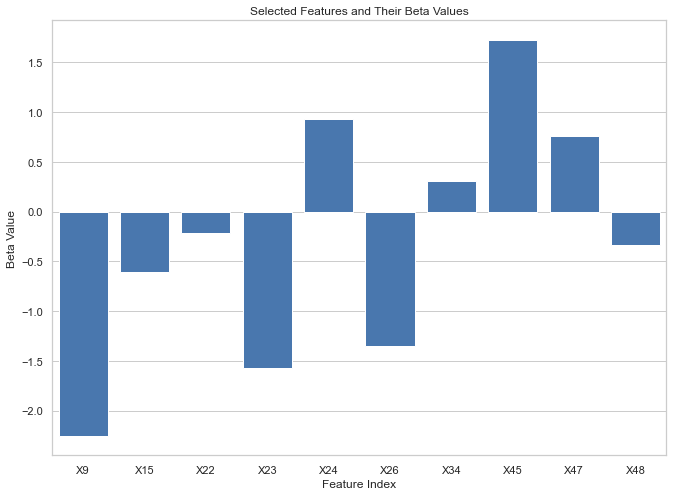

In [81]:
features_df = final_df.drop(columns=['beta_0'])

# Filter out features with non-zero beta values
non_zero_betas = features_df.loc[:, (features_df != 0).any(axis=0)]

# Create a mapping from beta column names to feature names
beta_to_feature_mapping = {f'beta_{i}': f'X{i}' for i in range(1, 51)}

# Apply the mapping to rename columns
renamed_features_df = non_zero_betas.rename(columns=beta_to_feature_mapping)

# Set the Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(11, 8))

# Use a single solid color for all bars
# bar_color = sns.color_palette("Set3")[4]

# Plot the beta values for selected features
sns.barplot(data=renamed_features_df.transpose().reset_index(), x='index', y=0, color="#3876BF")

# Add labels and title
plt.xlabel('Feature Index')
plt.ylabel('Beta Value')
plt.title('Selected Features and Their Beta Values')

# plt.savefig('feature_selection_miqp_1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Part 3
Once you find the k with the smallest cross validation error, fit the MIQP model on the
entire training set using that value of k. Use the 𝛽s you find in this MIQP to make a
prediction of the y values in the test set.

In [66]:
# Fit β using the entire training set with the selected best_k
best_beta = solve_MIQP(train_data, best_k, M, time_limit)

### Betas from MIQP

In [67]:
best_beta_values = np.array(best_beta).tolist()
best_beta_df = pd.DataFrame([best_beta_values], columns=[f"beta_{i}" for i in range(len(best_beta_values))])

best_beta_df

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,...,beta_41,beta_42,beta_43,beta_44,beta_45,beta_46,beta_47,beta_48,beta_49,beta_50
0,0.972524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.308207,...,0.0,0.0,0.0,0.0,1.781475,0.0,0.887383,-0.282292,0.0,0.0


### Selected features and corresponding betas after fitting MIQP model with entire training data

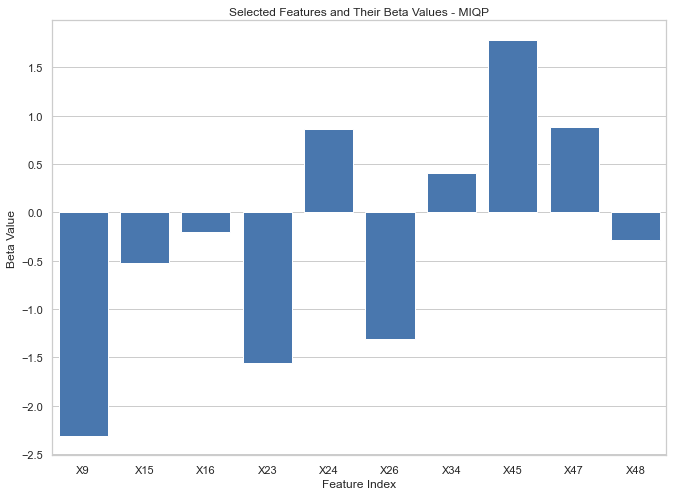

In [80]:
features_df = best_beta_df.drop(columns=['beta_0'])

# Filter out features with non-zero beta values
non_zero_betas = features_df.loc[:, (features_df != 0).any(axis=0)]

# Create a mapping from beta column names to feature names
beta_to_feature_mapping = {f'beta_{i}': f'X{i}' for i in range(1, 51)}

# Apply the mapping to rename columns
renamed_features_df = non_zero_betas.rename(columns=beta_to_feature_mapping)

# Set the Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(11, 8))

# Use a single solid color for all bars
# bar_color = sns.color_palette("Set3")[4]

# Plot the beta values for selected features
sns.barplot(data=renamed_features_df.transpose().reset_index(), x='index', y=0, color="#3876BF")

# Add labels and title
plt.xlabel('Feature Index')
plt.ylabel('Beta Value')
plt.title('Selected Features and Their Beta Values - MIQP')

# plt.savefig('feature_selection_miqp.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Predictions using betas from MIQP

In [71]:
if best_beta:
    # Make predictions on the test set using the obtained best_beta
    y_pred_MIQP = train_data.iloc[:, 1:].dot(best_beta[1:]) + best_beta[0]  # Predict on the test set

    # Calculate the train error
    MIQP_train_error = mean_squared_error(train_data["y"], y_pred_MIQP)
    print(f"Mean Squared Error on Train Set: {MIQP_train_error}")
    
    # Make predictions on the test set using the obtained best_beta
    y_pred_MIQP = test_data.iloc[:, 1:].dot(best_beta[1:]) + best_beta[0]  # Predict on the test set

    # Calculate the test error
    MIQP_test_error = mean_squared_error(test_data["y"], y_pred_MIQP)
    print(f"Mean Squared Error on Test Set: {MIQP_test_error}")
else:
    print("Unable to find a solution for best_k")
    
ytrue_ypred_MIQP = pd.DataFrame({'True_y': test_data['y'], 'Predicted_y': y_pred_MIQP, 'Residue': test_data['y'] - y_pred_MIQP})

ytrue_ypred_MIQP

Mean Squared Error on Train Set: 2.3919852662914574
Mean Squared Error on Test Set: 2.336543964552525


,True_y,Predicted_y,Residue
0,7.107949,6.179859,0.928090
1,5.796272,5.095243,0.701029
2,1.598651,3.285595,-1.686944
3,2.532953,3.758485,-1.225533
4,0.590685,-0.332975,0.923660
5,-6.108818,-5.142737,-0.966081
6,-1.993021,-3.144544,1.151523
7,-1.982904,-1.238063,-0.744841
8,0.134034,1.385111,-1.251077
9,-0.728690,-0.441739,-0.286952


## Part 4
Use scikit learn to do 10-fold cross validation on the training set to pick 𝜆 for LASSO.
Once you find the best value of 𝜆, fit a LASSO model to the entire training set using that
value of 𝜆. With the 𝛽s you find in that LASSO model make a prediction of the y values
in the test set.

In [72]:
# Separate the features and target variable for training and test sets
X_train = train_data.drop(columns=['y'])
y_train = train_data['y']

X_test = test_data.drop(columns=['y'])
y_test = test_data['y']

# Instantiate the StandardScaler and fit_transform on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the LassoCV model and perform 10-fold cross-validation on the training set
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_  # Best value of 𝜆
print(f"Best Lambda: {best_alpha}")

# Fit the LASSO model to the entire training set using the best 𝜆
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_pred_train = lasso.predict(X_train_scaled)

# Assess the training error using mean squared error (MSE)
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
print(f"Mean Squared Error on Train Set: {mse_train_lasso}")

# Make predictions on the test set
y_pred_lasso = lasso.predict(X_test_scaled)

# Create a DataFrame with true values, predicted values, and residues
ytrue_ypred_lasso = pd.DataFrame({'True_y': y_test, 'Predicted_y': y_pred_lasso, 'Residue': y_test - y_pred_lasso})

# Assess the test error using mean squared error (MSE)
mse_test_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Squared Error on Test Set: {mse_test_lasso}")

# Output the predictions or use them for further analysis
ytrue_ypred_lasso

Best Lambda: 0.08471942409934509
Mean Squared Error on Train Set: 2.3864444924068957
Mean Squared Error on Test Set: 2.356666383215587


,True_y,Predicted_y,Residue
0,7.107949,6.054521,1.053427
1,5.796272,4.870655,0.925616
2,1.598651,3.202654,-1.604003
3,2.532953,3.544853,-1.011901
4,0.590685,-0.464032,1.054717
5,-6.108818,-4.893368,-1.215450
6,-1.993021,-2.801400,0.808379
7,-1.982904,-1.464151,-0.518753
8,0.134034,1.386181,-1.252146
9,-0.728690,-0.176871,-0.551819


### Betas from Lasso

In [73]:
lasso_betas = [lasso.intercept_]
for coef in lasso.coef_:
    lasso_betas.append(coef)
    
# DataFrame with betas from LASSO
lasso_betas_df = pd.DataFrame([lasso_betas], columns=[f"beta_{i}" for i in range(len(lasso_betas))])

lasso_betas_df

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,...,beta_41,beta_42,beta_43,beta_44,beta_45,beta_46,beta_47,beta_48,beta_49,beta_50
0,1.276232,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-2.719827,...,-0.0,0.0,0.0,0.018689,1.631964,-0.01839,0.693846,-0.084735,0.0,0.0


### Selected features and corresponding betas from Lasso

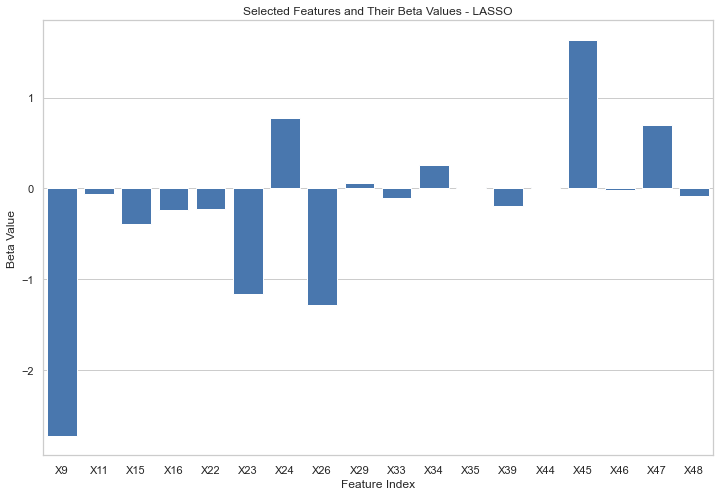

In [74]:
features_df = lasso_betas_df.drop(columns=['beta_0'])

# Filter out features with non-zero beta values
non_zero_betas = features_df.loc[:, (features_df != 0).any(axis=0)]

# Create a mapping from beta column names to feature names
beta_to_feature_mapping = {f'beta_{i}': f'X{i}' for i in range(1, 51)}

# Apply the mapping to rename columns
renamed_features_df = non_zero_betas.rename(columns=beta_to_feature_mapping)

# Set the Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Use a single solid color for all bars
# bar_color = sns.color_palette("Set3")[4]

# Plot the beta values for selected features
sns.barplot(data=renamed_features_df.transpose().reset_index(), x='index', y=0, color="#3876BF")

# Add labels and title
plt.xlabel('Feature Index')
plt.ylabel('Beta Value')
plt.title('Selected Features and Their Beta Values - LASSO')

# plt.savefig('feature_selection_lasso.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

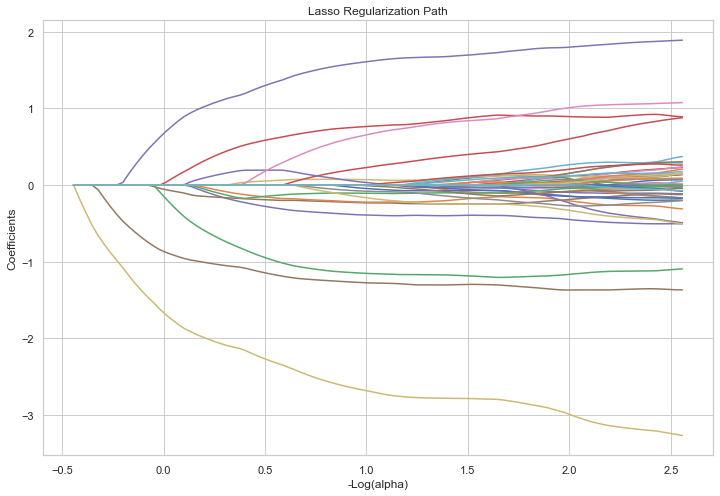

In [75]:
# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, eps=1e-3)

# Plotting the Lasso path
plt.figure(figsize=(12, 8))
log_alphas = -np.log10(alphas_lasso)
for i in range(coefs_lasso.shape[0]):
    plt.plot(log_alphas, coefs_lasso[i, :])

plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Regularization Path')

# plt.savefig('lasso_regularization_path.png', dpi=300, bbox_inches='tight')

plt.show()

## Part 5
Pretend that you are a junior consultant at an analytics consulting firm. You frequently
use LASSO in your job, but your boss has heard that the computational time of direct
variable selection has decreased with the advent of better solvers. Your boss wants you
to figure out if the firm should shift away from using LASSO to incorporate more direct
variable selection. Write this project as if this is what you’re going to deliver to your
boss. Describe the advantages and disadvantages of both techniques. Your boss is
pretty technical and understands optimization, so don’t be afraid to include quantitative
material. Your boss is also busy, so be sure to include some visualizations to get the
important points across. For the purpose of your report, you can assume that your boss
is interested in the data posted with the project.

### Train and Test Error Comparsions for MIQP & Lasso

In [76]:
import pandas as pd

# Define error values
errors = {
    "MIQP": {"Train Error": MIQP_train_error, "Test Error": MIQP_test_error},
    "Lasso": {"Train Error": mse_train_lasso, "Test Error": mse_test_lasso}
}

# Convert the dictionary to a DataFrame
error_df = pd.DataFrame(errors)
error_df = error_df.T

error_df

,Train Error,Test Error
MIQP,2.391985,2.336544
Lasso,2.386444,2.356666


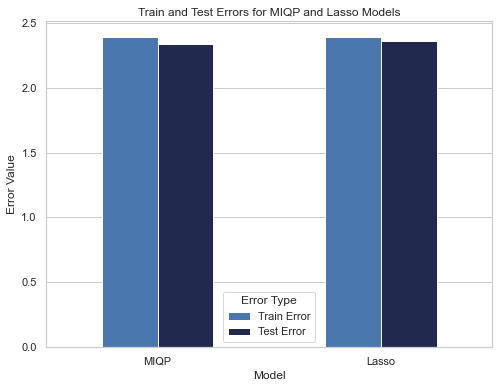

In [77]:
# Melt the DataFrame to long format for easier plotting with Seaborn
long_error_df = error_df.reset_index().melt(id_vars='index', var_name='Error Type', value_name='Error Value')
long_error_df.rename(columns={'index': 'Model'}, inplace=True)

# Set the Seaborn style
sns.set(style="whitegrid")

# Define a custom color palette
custom_palette = ["#3876BF", "#192655"]

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Error Value', hue='Error Type', data=long_error_df, palette=custom_palette, width=0.5)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Error Value')
plt.title('Train and Test Errors for MIQP and Lasso Models')

# Improve the legend
ax.legend(title='Error Type')

# plt.savefig('error_comparisions.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Comparision of Model Fit

In [100]:
ytrue_ypred_MIQP.head()

,True_y,Predicted_y,Residue
0,7.107949,6.179859,0.928090
1,5.796272,5.095243,0.701029
2,1.598651,3.285595,-1.686944
3,2.532953,3.758485,-1.225533
4,0.590685,-0.332975,0.923660


In [101]:
ytrue_ypred_lasso.head()

,True_y,Predicted_y,Residue
0,7.107949,6.054521,1.053427
1,5.796272,4.870655,0.925616
2,1.598651,3.202654,-1.604003
3,2.532953,3.544853,-1.011901
4,0.590685,-0.464032,1.054717


#### Assessing MIQP Model Fit

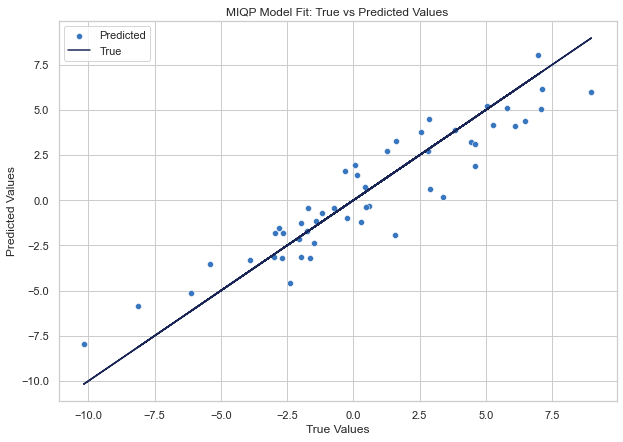

In [102]:
df = ytrue_ypred_MIQP

custom_palette = ["#3876BF", "#192655"]

# Plot
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Scatter plot of True vs Predicted values
sns.scatterplot(x='True_y', y='Predicted_y', data=df, color=custom_palette[0], label='Predicted')

# Line for perfect predictions
plt.plot(df['True_y'], df['True_y'], color=custom_palette[1], label='True')

plt.title('MIQP Model Fit: True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# plt.savefig('MIQP_fit.png', dpi=300, bbox_inches='tight')

plt.show()

#### Assessing MIQP model residue plot

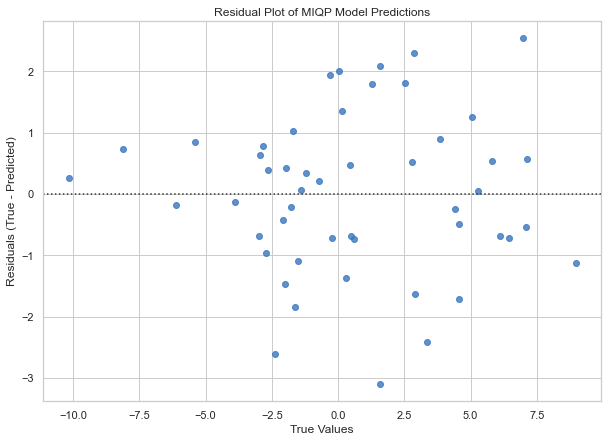

In [103]:
# Creating a residual plot
plt.figure(figsize=(10, 7))
sns.residplot(x='True_y', y='Predicted_y', data=df, color="#3876BF")

plt.title('Residual Plot of MIQP Model Predictions')
plt.xlabel('True Values')
plt.ylabel('Residuals (True - Predicted)')

# plt.savefig('MIQP_residue.png', dpi=300, bbox_inches='tight')

plt.show()

#### Assessing Lasso model fit

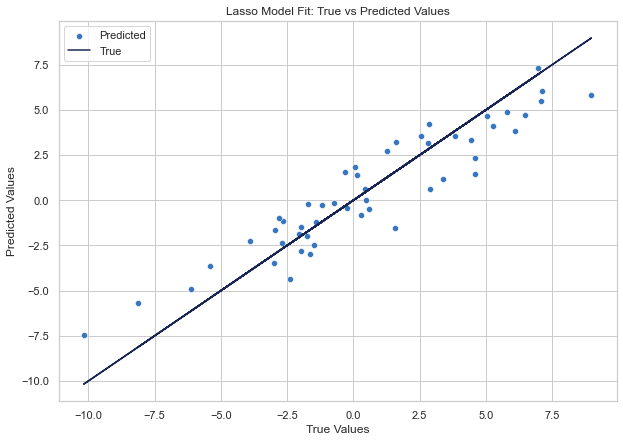

In [104]:
df2 = ytrue_ypred_lasso

custom_palette = ["#3876BF", "#192655"]

# Plot
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Scatter plot of True vs Predicted values
sns.scatterplot(x='True_y', y='Predicted_y', data=df2, color=custom_palette[0], label='Predicted')

# Line for perfect predictions
plt.plot(df2['True_y'], df2['True_y'], color=custom_palette[1], label='True')

plt.title('Lasso Model Fit: True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# plt.savefig('Lasso_fit.png', dpi=300, bbox_inches='tight')

plt.show()

#### Assessing Lasso residue plot

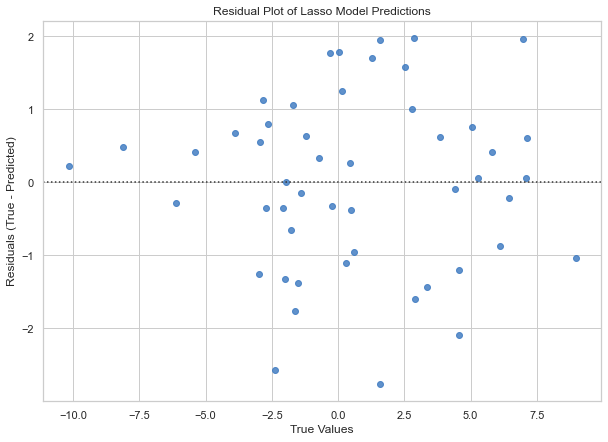

In [116]:
# Creating a residual plot
plt.figure(figsize=(10, 7))
sns.residplot(x='True_y', y='Predicted_y', data=df2, color="#3876BF")

plt.title('Residual Plot of Lasso Model Predictions')
plt.xlabel('True Values')
plt.ylabel('Residuals (True - Predicted)')

# plt.savefig('Lasso_residue.png', dpi=300, bbox_inches='tight')

plt.show()

#### Computed R-squared to better understand the fit of data

In [114]:
# Calculate the Total Sum of Squares (SST)
sst = ((test_data['y'] - test_data['y'].mean()) ** 2).sum()

# Calculate the Residual Sum of Squares (SSR)
ssr = ((test_data['y'] - ytrue_ypred_MIQP['Predicted_y']) ** 2).sum()

# Calculate R-squared
r_squared_miqp = 1 - (ssr / sst)

print(f"R-Squared for MIQP model: {r_squared_miqp}")

R-Squared for MIQP model: 0.8586682910020945


In [115]:
r_squared_lasso = lasso.score(X_test, y_test)
print(f"R-Squared for LASSO model: {r_squared_lasso}")

R-Squared for LASSO model: 0.8401916743405612


### Acknowledgements

For assistance with data visualization and related code in this notebook, we referred ChatGPT, lecture slides, and notebooks